# TO-DO
- Melhorar performance do modelo

# Importar bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import zscore

import glob
import os
import io
import csv

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import (mean_absolute_error,
                            mean_squared_error,
                            r2_score)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline

import os
# from google.colab import drive
# drive.mount('/content/gdrive')

# from google.colab import auth
# auth.authenticate_user()

# import gspread
# from google.auth import default
# creds, _ = default()

# gc = gspread.authorize(creds)

# Ler todos os arquivos particionados e condensá-los em apenas um

In [2]:
def load_and_merge(folder_path, info=True):
    # Encontrar todos os arquivos .csv no diretório especificado
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

    data_frames = []

    for file in csv_files:
        try:
            df = pd.read_csv(file, delimiter=',', on_bad_lines='skip')
            data_frames.append(df)
        except pd.errors.ParserError as e:
            print(f"Error parsing {file}: {e}")

    # Verificar se há data frames válidos para concatenar
    if data_frames:
        merged_df = pd.concat(data_frames, ignore_index=True)
    else:
        print("No valid data frames to concatenate.")
        return None

    if info and merged_df is not None:
        if len(merged_df) > 0:
            print("# Data imported!")
            print("# ------------------------------------\n")

            print("# DIMENSIONS -------------------------")
            print("Observation:", merged_df.shape[0], "Column:", merged_df.shape[1], "\n")

            print("# DTYPES -----------------------------")
            if len(merged_df.select_dtypes("object").columns) > 0:
                print("Object Variables:\n# of Variables:",
                      len(merged_df.select_dtypes("object").columns), "\n",
                      merged_df.select_dtypes("object").columns.tolist(), "\n")

            if len(merged_df.select_dtypes("integer").columns) > 0:
                print("Integer Variables:\n# of Variables:",
                      len(merged_df.select_dtypes("integer").columns), "\n",
                      merged_df.select_dtypes("integer").columns.tolist(), "\n")

            if len(merged_df.select_dtypes("float").columns) > 0:
                print("Float Variables:\n# of Variables:",
                      len(merged_df.select_dtypes("float").columns), "\n",
                      merged_df.select_dtypes("float").columns.tolist(), "\n")

            if len(merged_df.select_dtypes("bool").columns) > 0:
                print("Bool Variables:\n# of Variables:",
                      len(merged_df.select_dtypes("bool").columns), "\n",
                      merged_df.select_dtypes("bool").columns.tolist(), "\n")

            print("# MISSING VALUE ---------------------")
            print("Are there any missing values?\n",
                  "No missing value!" if not merged_df.isnull().values.any() else "Data includes missing value!", "\n")

            buf = io.StringIO()
            merged_df.info(buf=buf)
            info_memory = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info_memory)

        else:
            print("# Data did not import!")

    return merged_df

In [3]:
folder_path = r'C:\Users\paulo\OneDrive\Área de Trabalho\TCC\dados 2025\CM2 DADOS APOS PARADA'
df_raw = load_and_merge(folder_path, info=True)
df_raw.head()

# Data imported!
# ------------------------------------

# DIMENSIONS -------------------------
Observation: 236160 Column: 91 

# DTYPES -----------------------------
Object Variables:
# of Variables: 1 
 ['Timestamps'] 

Integer Variables:
# of Variables: 14 
 ['CM2_PV_PRODUCT', 'CM2_PV_FN01_POWER', 'CM2_PV_VRM01_POWER', 'CM2_LB_BLAINE_CPIIF', 'CM2_ST_CLA01_SPEED', 'CM2_ST_DA01_POSITION', 'CM2_ST_WI01_WATER_INJECTION', 'CM2_ST_VRM01_PRESS_GRIDING_1_3', 'CM2_ST_RB01_TOTAL_FEED', 'CM2_ST_GAS01_ADDITIVE_INJECTION', 'CM2_ST_DA02_SPA_PRESS', 'CM2_ST_IA_ENABLE', 'CM2_ST_IA_READY', 'CM2_ST_IA_USE'] 

Float Variables:
# of Variables: 76 
 ['CM2_PV_BE01_CURRENT', 'CM2_PV_BE02_POWER', 'CM2_PV_BF01_OUT_TEMPERATURE', 'CM2_PV_BF01_PRESSURE', 'CM2_PV_BF01_DIF_PRESSURE', 'CM2_PV_BF01_DIF_PRESSURE1', 'CM2_FLOW_RATE_COAL', 'CM2_PV_CLA01_POWER', 'CM2_PV_CLA01_SPEED', 'CM2_SP_CLA01_SPEED', 'CM2_PV_DA01_POSITION', 'CM2_SP_DA01_POSITION', 'CM2_PV_DA02_POSITION', 'CM2_SP_PRESS_MODE', 'CM2_SP_PRESS_AUTO', 

,Timestamps,CM2_PV_PRODUCT,CM2_PV_BE01_CURRENT,CM2_PV_BE02_POWER,CM2_PV_BF01_OUT_TEMPERATURE,CM2_PV_BF01_PRESSURE,CM2_PV_BF01_DIF_PRESSURE,CM2_PV_BF01_DIF_PRESSURE1,CM2_FLOW_RATE_COAL,CM2_PV_CLA01_POWER,...,CM2_ST_IA_READY,CM2_ST_IA_USE,CM2_IA_CLA01_SP_SPEED,CM2_IA_DA01_SP_POSITION,CM2_IA_DA02_SPA_PRESS,CM2_IA_GAS01_SP_FLOW_AID,CM2_IA_RB01_SP_TOTAL_FEED,CM2_IA_VRM01_SP_PRESS_GRIDING,CM2_IA_WI01_SP_WATER_INJECTION,CM2_IA_SC01_SPA_TEMP_OUT
0,01/01/2025 00:00:00,6,0.0,0.0,41.644386,0.286501,0.053487,3.974631,0.0,0.0,...,0,0,69.0,83.0,-5.0,25.974026,80.5,5.6,2900.0,98.0
1,01/01/2025 00:00:30,6,0.0,0.0,41.622430,0.273111,0.053425,3.974594,0.0,0.0,...,0,0,69.0,83.0,-5.0,25.974026,80.5,5.6,2900.0,98.0
2,01/01/2025 00:01:00,6,0.0,0.0,41.600468,0.239829,0.053363,3.974557,0.0,0.0,...,0,0,69.0,83.0,-5.0,25.974026,80.5,5.6,2900.0,98.0
3,01/01/2025 00:01:30,6,0.0,0.0,41.578510,0.271138,0.053301,3.974520,0.0,0.0,...,0,0,69.0,83.0,-5.0,25.974026,80.5,5.6,2900.0,98.0
4,01/01/2025 00:02:00,6,0.0,0.0,41.556550,0.288582,0.053239,3.974483,0.0,0.0,...,0,0,69.0,83.0,-5.0,25.974026,80.5,5.6,2900.0,98.0


In [4]:
df = df_raw#.iloc[:30000]

In [5]:
# Tratar dados em relação a Timestamps

df['Timestamps'] = pd.to_datetime(df.Timestamps, format='%d/%m/%Y %H:%M:%S', dayfirst=True)

df.sort_values(by=['Timestamps'], inplace=True, ascending=True)

df = df.drop_duplicates('Timestamps')

df = df.set_index('Timestamps')

In [6]:
fig = px.line(df, x=df.index, y='CM2_PV_VRM01_VIBRATION',
              title='Vibração CM2_PV_VRM01',
              labels={'x': 'Data/Hora', 'CM2_PV_VRM01_VIBRATION': 'Vibração'})

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [6]:
min_date = df.index.min()
max_date = df.index.max()

print("Min date:", min_date)
print("Max date:", max_date)

Min date: 2025-01-01 00:00:00
Max date: 2025-03-23 23:59:30


In [7]:
df = df.loc['2025-02-07':'2025-03-23']

# Funções

Plotar histogramas

In [8]:
def hist(df, ncols=5, figsize=(20, 15)):
    """
    Plota histogramas para cada coluna em um DataFrame, com múltiplas variáveis distribuídas em subplots.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    ncols (int): Número de colunas de subplots por linha. Padrão é 5.
    figsize (tuple): Tamanho da figura do plot. Padrão é (20, 15).

    Retorna:
    Hist plot.
    """
    num_columns = df.shape[1]
    nrows = math.ceil(num_columns / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Criar os histogramas
    for i, col in enumerate(df.columns):
        df[col].hist(ax=axes[i], bins=100)
        axes[i].set_title(col)

    # Remover subplots vazios
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.subplots_adjust(hspace=1, wspace=1)  # Ajustar os espaçamentos
    plt.show()

Plotar séries temporais

In [9]:
def time_series(df, cols_per_row=3, figsize=(20, 50)):
    """
    Plota séries temporais de um DataFrame, com múltiplas variáveis distribuídas em subplots.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo as séries temporais.
    cols_per_row (int): Número de colunas de subplots por linha. Padrão é 3.
    figsize (tuple): Tamanho da figura do plot. Padrão é (20, 50).

    Retorna:
    Timeseries plot.
    """
    num_vars = len(df.columns)
    num_rows = math.ceil(num_vars / cols_per_row)

    fig, axs = plt.subplots(num_rows, cols_per_row, figsize=figsize)
    axs = axs.flatten()  # Flatten para facilitar o indexamento

    # Plotando cada variável em um subplot
    for i, column in enumerate(df.columns):
        axs[i].plot(df.index, df[column])
        axs[i].set_title(f'Time Series of {column}')
        axs[i].grid(False)

    # Remover subplots vazios
    for i in range(num_vars, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

Plotar scatter plot

In [10]:
def scatter_target(df, target_column='CM2_PV_VRM01_VIBRATION', cols_per_row=3, figsize=(20, 5)):
    """
    Plota gráficos de dispersão de cada coluna em relação a uma coluna de destino especificada.
    Mostra a correlação de Pearson (r) para cada subplot.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    target_column (str): Nome da coluna de destino para comparação. Padrão é 'CD1_PV_VRM01_VIBRATION'.
    cols_per_row (int): Número de colunas de subplots por linha. Padrão é 3.
    figsize (tuple): Tamanho base da figura do plot. A altura é ajustada automaticamente conforme necessário.

    Retorna:
    None
    """
    num_vars = len(df.columns)
    num_rows = math.ceil((num_vars - 1) / cols_per_row)  # Subtraímos 1 para não incluir a coluna de destino

    fig, axs = plt.subplots(num_rows, cols_per_row, figsize=(figsize[0], figsize[1] * num_rows))
    axs = axs.flatten()  # Flatten para facilitar o indexamento

    # Plotando cada variável em relação à coluna de destino
    plot_idx = 0
    for i, column in enumerate(df.columns):
        if column != target_column:  # Ignorar a coluna de destino para não se comparar com ela mesma
            r = df[column].corr(df[target_column])  # Calculando a correlação de Pearson
            axs[plot_idx].scatter(df[column], df[target_column])
            axs[plot_idx].set_title(f'{column} vs {target_column}\n$r={r:.2f}$')
            axs[plot_idx].grid(False)
            plot_idx += 1

    # Remover subplots vazios
    for i in range(plot_idx, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

Plotar heatmap

In [11]:
def corr_matrix_target(df, target_column='CM2_PV_VRM01_VIBRATION', threshold=0.4, figsize=(10, 8), cmap='coolwarm'):
    """
    Plota um heatmap da matriz de correlação filtrada, mostrando apenas correlações acima de um valor absoluto específico.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    target_column (str): Nome da coluna de destino para filtragem de correlações. Padrão é 'CD1_PV_VRM01_VIBRATION'.
    threshold (float): Valor absoluto mínimo de correlação para inclusão no heatmap. Padrão é 0.4.
    figsize (tuple): Tamanho da figura do heatmap. Padrão é (10, 8).
    cmap (str): Mapa de cores para o heatmap. Padrão é 'coolwarm'.

    Retorna:
    None
    """
    # Calcular a matriz de correlação
    correlation_matrix = df.corr()

    # Filtrar as correlações com a coluna de destino
    correlation_with_target = correlation_matrix[target_column]

    # Selecionar variáveis com correlação maior que o limiar especificado
    selected_columns = correlation_with_target[abs(correlation_with_target) > threshold].index

    # Gerar a matriz de correlação filtrada
    filtered_correlation_matrix = correlation_matrix.loc[selected_columns, selected_columns]

    # Plotar o heatmap da matriz de correlação filtrada
    plt.figure(figsize=figsize)
    sns.heatmap(filtered_correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5)
    plt.title(f'Matriz de Correlação (acima de {threshold} em valor absoluto)')
    plt.show()

Tabela de correlação com vibração

In [12]:
def corr_target(df, target_column='CM2_PV_VRM01_VIBRATION', benchmark=0.4):
    """
    Retorna uma tabela de correlações filtrada mostrando apenas variáveis com correlação relevante em relação à coluna de destino.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    target_column (str): Nome da coluna de destino para filtragem de correlações. Padrão é 'CD1_PV_VRM01_VIBRATION'.
    benchmark (float): Valor mínimo absoluto de correlação para inclusão na tabela. Padrão é 0.4.

    Retorna:
    pd.DataFrame: DataFrame contendo variáveis e suas correlações com a coluna de destino.
    """
    # Calcular a matriz de correlação
    correlation_matrix = df.corr()

    # Filtrar as correlações com a coluna de destino
    correlation_with_target = correlation_matrix[target_column]

    # Criar uma tabela filtrada pelas correlações relevantes
    filtered_correlations = correlation_with_target[
        (correlation_with_target.abs() >= benchmark) &
        (correlation_with_target.index != target_column)
    ].sort_values(ascending=False).to_frame().reset_index()

    filtered_correlations.columns = ['Variable', 'Correlation to Vibration']

    return filtered_correlations

Boxplots

In [13]:
def boxplots(df, num_cols=3, figsize=(20, 5)):
    """
    Plota boxplots para cada coluna em um DataFrame, com múltiplas variáveis distribuídas em subplots.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    num_cols (int): Número de colunas de subplots por linha. Padrão é 3.
    figsize (tuple): Tamanho base da figura do plot. A altura é ajustada automaticamente conforme necessário.

    Retorna:
    None
    """
    # Filtrar apenas colunas numéricas
    numeric_columns = df.select_dtypes(include='number').columns
    num_vars = len(numeric_columns)

    if num_vars == 0:
        raise ValueError("O DataFrame não contém colunas numéricas para plotar.")

    num_rows = math.ceil(num_vars / num_cols)  # Ajustar o número de linhas

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(figsize[0], figsize[1] * num_rows))
    axs = axs.flatten()  # Flatten para facilitar o indexamento

    # Plotando boxplots para cada variável numérica
    for i, column in enumerate(numeric_columns):
        sns.boxplot(data=df[column], ax=axs[i])
        axs[i].set_title(f'Boxplot: {column}')
        axs[i].set_xlabel(column)
        axs[i].grid(True)

    # Remover subplots vazios
    for i in range(num_vars, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

Z-score

In [14]:
def zscore(df, max_vars_per_plot=10, num_cols=2, figsize=(20, 5)):
    """
    Plota boxplots dos Z-scores para cada coluna numérica em um DataFrame, organizando em grupos de variáveis.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    max_vars_per_plot (int): Número máximo de variáveis por plot. Padrão é 10.
    num_cols (int): Número de colunas de subplots por linha. Padrão é 2.
    figsize (tuple): Tamanho base da figura do plot. A altura é ajustada automaticamente conforme necessário.

    Retorna:
    None
    """
    # Calculando os Z-scores
    z_scores = zscore(df.select_dtypes(include=['float64', 'int64']))

    # Convertendo os Z-scores em um DataFrame
    z_scores_df = pd.DataFrame(z_scores, columns=df.select_dtypes(include=['float64', 'int64']).columns)

    # Dividindo as colunas em grupos de no máximo max_vars_per_plot
    columns = z_scores_df.columns
    column_groups = [columns[i:i + max_vars_per_plot] for i in range(0, len(columns), max_vars_per_plot)]

    # Calcular o número de linhas necessário
    num_rows = int(np.ceil(len(column_groups) / num_cols))

    # Criando o layout
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(figsize[0], figsize[1] * num_rows))
    axs = axs.flatten()  # Flatten para facilitar o indexamento

    # Plotando cada grupo em um subplot
    for i, group in enumerate(column_groups):
        sns.boxplot(data=z_scores_df[group], ax=axs[i])
        axs[i].set_title(f'Boxplot dos Z-scores (Grupo {i + 1})')
        axs[i].set_xlabel('Variáveis')
        axs[i].set_ylabel('Z-score')
        axs[i].tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo X
        axs[i].grid(True)

    # Removendo subplots vazios
    for j in range(len(column_groups), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

In [15]:
# Função para plotar histogramas comparando original x iqr x zscore
def plot_histograms(data_original, data_iqr, data_zscore, columns):
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 3, figsize=(15, num_columns * 4))

    for i, column in enumerate(columns):
        # Plotar histograma para os dados originais
        axes[i, 0].hist(data_original[column].dropna(), bins=30, alpha=0.7, color='blue')
        axes[i, 0].set_title(f'Original - {column}')

        # Plotar histograma para os dados após remoção de outliers pelo método IQR
        axes[i, 1].hist(data_iqr[column].dropna(), bins=30, alpha=0.7, color='green')
        axes[i, 1].set_title(f'IQR - {column}')

        # Plotar histograma para os dados após remoção de outliers pelo método Z-Score
        axes[i, 2].hist(data_zscore[column].dropna(), bins=30, alpha=0.7, color='red')
        axes[i, 2].set_title(f'Z-Score - {column}')

    plt.tight_layout()
    plt.show()

# Tratar dados

In [16]:
null_counts = df.isnull().sum()
null_counts[null_counts > 0]

,0


# EDA

In [17]:
df.head()

,CM2_PV_PRODUCT,CM2_PV_BE01_CURRENT,CM2_PV_BE02_POWER,CM2_PV_BF01_OUT_TEMPERATURE,CM2_PV_BF01_PRESSURE,CM2_PV_BF01_DIF_PRESSURE,CM2_PV_BF01_DIF_PRESSURE1,CM2_FLOW_RATE_COAL,CM2_PV_CLA01_POWER,CM2_PV_CLA01_SPEED,...,CM2_ST_IA_READY,CM2_ST_IA_USE,CM2_IA_CLA01_SP_SPEED,CM2_IA_DA01_SP_POSITION,CM2_IA_DA02_SPA_PRESS,CM2_IA_GAS01_SP_FLOW_AID,CM2_IA_RB01_SP_TOTAL_FEED,CM2_IA_VRM01_SP_PRESS_GRIDING,CM2_IA_WI01_SP_WATER_INJECTION,CM2_IA_SC01_SPA_TEMP_OUT
Timestamps,,,,,,,,,,,,,,,,,,,,,
2025-02-07 00:00:00,2,42.066210,50.647892,93.380880,-63.542378,9.975696,3.575776,660.639343,79.45779,1642.94653,...,1,1,92.0,78.0,-4.505993,25.974026,66.0,5.6,3200.0,102.0
2025-02-07 00:00:30,2,44.448270,64.028080,93.348290,-63.328180,9.964844,3.720656,660.397034,78.02518,1644.18262,...,1,1,92.0,78.0,-4.516964,25.974026,66.0,5.6,3200.0,102.0
2025-02-07 00:01:00,2,42.447033,55.684673,93.315700,-63.377300,10.269734,3.059598,660.630700,79.52994,1643.56067,...,1,1,92.0,78.0,-4.545940,25.974026,66.0,5.6,3200.0,102.0
2025-02-07 00:01:30,2,44.345898,55.444237,93.283104,-63.997090,9.524961,2.933050,660.424255,81.19316,1640.86035,...,1,1,92.0,78.0,-4.550999,25.974026,66.0,5.6,3200.0,102.0
2025-02-07 00:02:00,2,42.915485,50.250110,93.250510,-63.868984,9.679323,3.103921,660.602051,80.34723,1644.90000,...,1,1,92.0,78.0,-4.510601,25.974026,66.0,5.6,3200.0,102.0


In [18]:
df.columns

Index(['CM2_PV_PRODUCT', 'CM2_PV_BE01_CURRENT', 'CM2_PV_BE02_POWER',
       'CM2_PV_BF01_OUT_TEMPERATURE', 'CM2_PV_BF01_PRESSURE',
       'CM2_PV_BF01_DIF_PRESSURE', 'CM2_PV_BF01_DIF_PRESSURE1',
       'CM2_FLOW_RATE_COAL', 'CM2_PV_CLA01_POWER', 'CM2_PV_CLA01_SPEED',
       'CM2_SP_CLA01_SPEED', 'CM2_PV_DA01_POSITION', 'CM2_SP_DA01_POSITION',
       'CM2_PV_DA02_POSITION', 'CM2_SP_PRESS_MODE', 'CM2_SP_PRESS_AUTO',
       'CM2_SP_PRESS_MANUAL', 'CM2_PV_FN01_POWER', 'CM2_SP_GA01_SPM',
       'CM2_PV_HG01_TEMPERATURE', 'CM2_PV_HG01_TEMPERATURE1',
       'CM2_PV_HG01_TEMPERATURE2', 'CM2_PV_HYS01_PRESSURE',
       'CM2_PV_HYS01_PRESSURE1', 'CM2_SP_RB01_MILL_TOTAL_FEED',
       'CM2_SP_RB01_MODE_TOTAL_FEED', 'CM2_SP_RB01_SPA_TOTAL_FEED',
       'CM2_SP_RB01_TOTAL_FEED', 'CM2_PV_RB01_TOTAL_FEED',
       'CM2_PV_RF01_CURRENT', 'CM2_SP_VRM01_TEMP_MODE',
       'CM2_SP_VRM01_TEMP_AUTO', 'CM2_SP_VRM01_TEMP_MANUAL',
       'CM2_SP_VRM01_PRESS_GRIDING_1_3', 'CM2_SP_VRM01_PRESS_GRIDING_2_4',
       

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129600 entries, 2025-02-07 00:00:00 to 2025-03-23 23:59:30
Data columns (total 90 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   CM2_PV_PRODUCT                   129600 non-null  int64  
 1   CM2_PV_BE01_CURRENT              129600 non-null  float64
 2   CM2_PV_BE02_POWER                129600 non-null  float64
 3   CM2_PV_BF01_OUT_TEMPERATURE      129600 non-null  float64
 4   CM2_PV_BF01_PRESSURE             129600 non-null  float64
 5   CM2_PV_BF01_DIF_PRESSURE         129600 non-null  float64
 6   CM2_PV_BF01_DIF_PRESSURE1        129600 non-null  float64
 7   CM2_FLOW_RATE_COAL               129600 non-null  float64
 8   CM2_PV_CLA01_POWER               129600 non-null  float64
 9   CM2_PV_CLA01_SPEED               129600 non-null  float64
 10  CM2_SP_CLA01_SPEED               129600 non-null  float64
 11  CM2_PV_DA01_POSITION           

Existem algumas variáveis sem dados. Por isso, serão retiradas.

In [ ]:
# df.drop(columns=['CD1_PV_FLOW_CLINQUER',
#                  'CD1_PV_FLOW_GESSO',
#                  'CD1_PV_FLOW_FLYASH',
#                  'CD1_PV_FLOW_CALCARIO',
#                  'CD1_PV_FLOW_ESCORIA',
#                  'CD1_PV_FLOW_BLEND',
#                  'CD1_PV_FLOW_POZZOLANA'], axis=1, inplace=True)

In [20]:
# remover linhas inteiras vazias
df = df.dropna(how='all')

# preencher vazios com média
df = df.apply(lambda x: x.fillna(x.mean()), axis=0)

In [21]:
df.shape

(129600, 90)

In [ ]:
df.describe()

In [ ]:
# histogramas das variáveis

hist(df)

In [ ]:
# series temporais das variáveis

time_series(df)

Algumas variáveis estão constantes ao longo do tempo. Portanto, serão removidas.

In [ ]:
scatter_target(df)

In [ ]:
corr_matrix_target(df)

In [ ]:
corr_target(df)

# Preparando os dados

In [22]:
df_model = df.copy()

### Remover outliers

In [ ]:
def remove_outliers_iqr(df):
    def iqr_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return (column < lower_bound) | (column > upper_bound)

    for column in df.select_dtypes(include=[np.number]).columns:
        outliers = iqr_outliers(df[column])
        df = df[~outliers]
    return df

def remove_outliers_zscore(df, threshold=3):
    from scipy.stats import zscore
    z_scores = np.abs(df.select_dtypes(include=[np.number]).apply(zscore))
    return df[(z_scores < threshold).all(axis=1)]

In [ ]:
data_limpo_iqr = remove_outliers_iqr(df_model)
data_limpo_zscore = remove_outliers_zscore(df_model)

Comparação entre os métodos de remoção de outliers IQR vs. Z-score

In [ ]:
print("Original Data Shape:", df.shape)
print("IQR Cleaned Data Shape:", data_limpo_iqr.shape)
print("Z-Score Cleaned Data Shape:", data_limpo_zscore.shape)

In [ ]:
# # Selecionar colunas numéricas para plotar
# columns = df_model.select_dtypes(include=[np.number]).columns

# # Plotar histogramas
# plot_histograms(df_model, data_limpo_iqr, data_limpo_zscore, columns)

O tratamento de outliers com o método IQR forneceu distribuições mais próximas à normalização. Portanto, ele foi escolhido.

In [ ]:
# df_model = data_limpo_iqr.copy()

### Estabelecer limites

In [ ]:
# Definindo o número de colunas para os subplots
ncols = 3
nrows = (len(df_model.columns) // ncols) + int(len(df_model.columns) % ncols != 0)

# Criando a figura e os subplots
plt.figure(figsize=(15, nrows * 5))

# Iterando sobre as colunas para gerar o boxplot de cada uma
for i, col in enumerate(df_model.columns):
    plt.subplot(nrows, ncols, i + 1)
    sns.boxplot(data=df_model, x=col)
    plt.title(f'Boxplot de {col}')
    plt.xticks(rotation=45)  # Para evitar sobreposição de labels, caso necessário

# Ajustando o layout
plt.tight_layout()
plt.show()

In [ ]:
df_model.columns

In [ ]:
# #df_model = df_model[(df_model['CD1_PV_VRM01_POWER'] > 600) & (df_model['CD1_PV_VRM01_POWER'] < 1600)]
# df_model = df_model[df_model['CD1_PV_VRM01_VIBRATION'] < 2.5]
# df_model = df_model[(df_model['CD1_PV_FN01_POWER'] > 300) & (df_model['CD1_PV_FN01_POWER'] < 500)]
# df_model = df_model[(df_model['CD1_PV_VRM01_DIF_PRESS'] > 15) & (df_model['CD1_PV_VRM01_DIF_PRESS'] < 30)]
# df_model = df_model[(df_model['CD1_PV_VRM01_PRESS_GRIDING'] > 80) & (df_model['CD1_PV_VRM01_PRESS_GRIDING'] < 130)]

In [ ]:
df_model.shape

### Feature importance

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Assume your DataFrame is called df and the target column is 'target'
X = df.drop(columns=['CM2_PV_VRM01_VIBRATION','CM2_PV_VRM01_VIBRATION1'])
y = df['CM2_PV_VRM01_VIBRATION']

# Split for training (optional but good practice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Extract importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier viewing
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

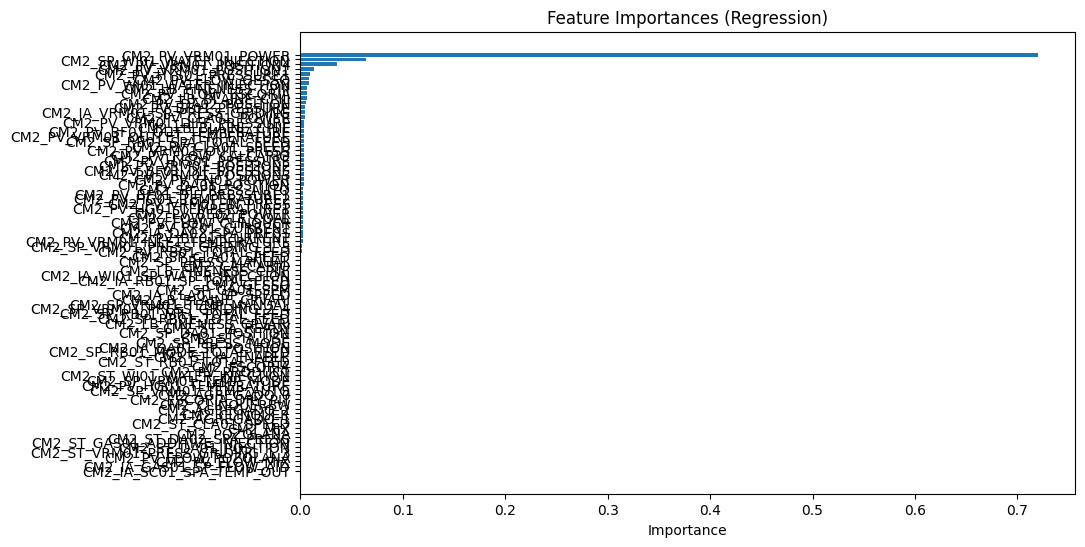

In [25]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances (Regression)')
plt.xlabel('Importance')
plt.show()

In [26]:
top_k = 10
top_features = feature_importance_df.head(top_k)['feature'].tolist()

# Add the specific feature manually if not already in the list
additional_feature = 'CM2_PV_VRM01_VIBRATION'
if additional_feature not in top_features:
    top_features.append(additional_feature)

df_model = df_model[top_features]

In [27]:
top_features

['CM2_PV_VRM01_POWER',
 'CM2_SP_WI01_WATER_INJECTION',
 'CM2_PV_VRM01_POSITION4',
 'CM2_PV_VRM01_POSITION1',
 'CM2_PV_HYS01_PRESSURE1',
 'CM2_PV_FLOW_GESSO',
 'CM2_PV_WI01_WATER_INJECTION',
 'CM2_LB_FINENESS_CPIII',
 'CM2_PV_FLOW_ESCORIA',
 'CM2_LB_BLAINE_CPIII',
 'CM2_PV_VRM01_VIBRATION']

top_features = ['CD1_SP_VRM01_POWER', 'CD1_PV_WF02_FLOW', 'CD1_PV_VRM01_IN_PRESS', 'CD1_PV_WF07_FLYASH2', 'CD1_PV_VRM01_DIF_PRESS', 'CD1_PV_VRM01_CURRENT', 'CD1_PV_FN01_POWER', 'CD1_PV_VRM01_PRESS_GRIDING', 'CD1_PV_WF03_FLOW', 'CD1_PV_VRM01_INLET_TEMPERATURE']

In [ ]:
df_model.shape

# Modelos

In [ ]:
df_model.columns

In [ ]:
df_model.head(10)

## Linear Regression

In [28]:
y = df_model['CM2_PV_VRM01_VIBRATION']
X = df_model.drop('CM2_PV_VRM01_VIBRATION', axis=1)

In [ ]:
# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=False)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Pipeline com ElasticNet e transformação polinomial
pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(), ElasticNet())

# Hiperparâmetros para busca em grade
param_grid = {
    'polynomialfeatures__degree': [3, 4, 5, 6],
    'elasticnet__alpha': [0.1, 1.0, 10.0],
    'elasticnet__l1_ratio': [0.5, 0.9]  # Combinação Lasso e Ridge
}

# Validação cruzada com TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=1)

# Ajuste do modelo
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

# Avaliação no conjunto de teste
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}')

# Validando o modelo com cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-np.mean(cv_scores)}")

Train shape: (110160, 10), Test shape: (19440, 10)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.912e+01, tolerance: 3.116e+00

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+02, tolerance: 1.453e+01

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.575e+02, tolerance: 2.092e+01

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_des

In [ ]:

# Criando o gráfico com o eixo X como os timestamps do DataFrame
plt.figure(figsize=(12, 6))

# Plotando os valores reais do treino (usando df.index para o eixo X)
plt.plot(df_model.index[:len(y_train)], y_train, label="Valores Reais (Treino)", color="blue", linewidth=2, alpha=0.7)

# Plotando os valores reais do teste (usando df.index)
plt.plot(df_model.index[len(y_train):len(y_train) + len(y_test)], y_test, label="Valores Reais (Teste)", color="green", linewidth=2, alpha=0.7)

# Plotando as previsões no teste (também com df.index), colocando à frente
plt.plot(df_model.index[len(y_train):len(y_train) + len(y_pred)], y_pred, label="Valores Preditos (Teste)", color="red", linestyle="--", linewidth=2, alpha=0.8)

# Linha de divisão entre treino e teste
plt.axvline(x=df_model.index[len(y_train)], color="black", linestyle="--", label="Divisão Treino/Teste")

# Configurando os rótulos e título
plt.xlabel("Tempo")
plt.ylabel("Valores")
plt.title("Valores Reais e Preditos (Treino + Teste)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Girando os rótulos de data no eixo X para facilitar a leitura
plt.tight_layout()

# Exibindo o gráfico
plt.show()


In [ ]:
y_test_subset = y_test
y_pred_subset = y_pred

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_subset.values, label='Observed')
plt.plot(y_pred_subset, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Observed vs Predicted Values')
plt.legend()
plt.show()

In [ ]:
resultados_lr = pd.DataFrame({
    'real': y_test,
    'predicted': y_pred
})

In [ ]:
resultados_lr = resultados_lr.sort_index()

# Plotar o gráfico de linhas
plt.figure(figsize=(20, 10))
plt.plot(resultados_lr.index, resultados_lr['real'], label='Real', color='blue', linewidth=2)
plt.plot(resultados_lr.index, resultados_lr['predicted'], label='Predicted', color='orange', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Vibration')
plt.title('Timeseries Real vs Predicted - Linear Regression Model')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Dividir o DataFrame em pedaços de n observações
n = 5000
chunks = [resultados_lr.iloc[i:i + n] for i in range(0, len(resultados_lr), n)]

# Definir o tamanho da figura e o número de colunas
fig, axs = plt.subplots(len(chunks) // 3 + 1, 3, figsize=(20, 15))
axs = axs.flatten()

# Plotar gráficos separados para cada pedaço
for i, chunk in enumerate(chunks):
    axs[i].plot(chunk.index, chunk['real'], label='Real', color='blue', linewidth=2)
    axs[i].plot(chunk.index, chunk['predicted'], label='Predicted', color='orange', linewidth=2)
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('Vibration')
    axs[i].set_title(f'Timeseries Real vs Predicted - Segment {i+1}')
    axs[i].legend()
    axs[i].grid(True)

# Remover eixos dos gráficos vazios, se houver
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
# Gráfico de Dispersão
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs. Valores Preditos')
plt.show()

# Gráfico de Resíduos
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.show()


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

# Definir param_grid para busca em grade
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Criar e ajustar o modelo usando GridSearchCV
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Melhor modelo após busca em grade
best_model = grid_search.best_estimator_

# Avaliando o modelo no conjunto de teste
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Melhores hiperparâmetros: {grid_search.best_params_}")
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}')

# Validando o modelo com cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
print(f"Cross-Validation MSE: {-np.mean(cv_scores)}")

In [ ]:
# Criando o gráfico com o eixo X como os timestamps do DataFrame
plt.figure(figsize=(12, 6))

# Plotando os valores reais do treino (usando df.index para o eixo X)
plt.plot(df_model.index[:len(y_train)], y_train, label="Valores Reais (Treino)", color="blue", linewidth=2, alpha=0.7)

# Plotando os valores reais do teste (usando df.index)
plt.plot(df_model.index[len(y_train):len(y_train) + len(y_test)], y_test, label="Valores Reais (Teste)", color="green", linewidth=2, alpha=0.7)

# Plotando as previsões no teste (também com df.index), colocando à frente
plt.plot(df_model.index[len(y_train):len(y_train) + len(y_pred)], y_pred, label="Valores Preditos (Teste)", color="red", linestyle="--", linewidth=2, alpha=0.8)

# Linha de divisão entre treino e teste
plt.axvline(x=df_model.index[len(y_train)], color="black", linestyle="--", label="Divisão Treino/Teste")

# Configurando os rótulos e título
plt.xlabel("Tempo")
plt.ylabel("Valores")
plt.title("Valores Reais e Preditos (Treino + Teste)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Girando os rótulos de data no eixo X para facilitar a leitura
plt.tight_layout()

# Exibindo o gráfico
plt.show()


In [ ]:
resultados_rf = pd.DataFrame({
    'real': y_test,
    'predicted': y_pred
})

In [ ]:
resultados_rf = resultados_lr.sort_index()

# Plotar o gráfico de linhas
plt.figure(figsize=(20, 10))
plt.plot(resultados_lr.index, resultados_lr['real'], label='Real', color='blue', linewidth=2)
plt.plot(resultados_lr.index, resultados_lr['predicted'], label='Predicted', color='orange', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Vibration')
plt.title('Timeseries Real vs Predicted - Random Forest Model')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Dividir o DataFrame em pedaços de n observações
n = 5000
chunks = [resultados_rf.iloc[i:i + n] for i in range(0, len(resultados_rf), n)]

# Definir o tamanho da figura e o número de colunas
fig, axs = plt.subplots(len(chunks) // 3 + 1, 3, figsize=(20, 15))
axs = axs.flatten()

# Plotar gráficos separados para cada pedaço
for i, chunk in enumerate(chunks):
    axs[i].plot(chunk.index, chunk['real'], label='Real', color='blue', linewidth=2)
    axs[i].plot(chunk.index, chunk['predicted'], label='Predicted', color='orange', linewidth=2)
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('Vibration')
    axs[i].set_title(f'Timeseries Real vs Predicted - Segment {i+1}')
    axs[i].legend()
    axs[i].grid(True)

# Remover eixos dos gráficos vazios, se houver
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
y_test_subset = y_test[:3000]
y_pred_subset = y_pred[:3000]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_subset.values, label='Observed')
plt.plot(y_pred_subset, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Observed vs Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Gráfico de Dispersão
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs. Valores Preditos')
plt.show()

# Gráfico de Resíduos
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.show()


## Long Short-Term Memory (LSTM)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


# Se 'y' for uma Series, converta para NumPy antes de redimensionar
y_array = y.values if isinstance(y, pd.Series) else y  # Convertendo Series para array
y_array = y_array.reshape(-1, 1)  # Redimensionar para 2D

# Normalização com escaladores separados para X e y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_array)

# Divisão do conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, train_size=0.7, shuffle=False)

# Transformar X para formato 3D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construção do modelo
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compilação e treinamento
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Previsão e reescalonamento
y_pred = model.predict(X_test)
y_test = scaler_y.inverse_transform(y_test)
y_pred = scaler_y.inverse_transform(y_pred)

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}')


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Observed')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Observed vs Predicted Values')
plt.legend()
plt.show()

In [ ]:
resultados_lstm = pd.DataFrame({
    'real': y_test.flatten(),
    'predicted': y_pred.flatten()
})

In [ ]:
# Gráfico de Dispersão
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs. Valores Preditos')
plt.show()

# Gráfico de Resíduos
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.show()
